In [27]:
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from collections import defaultdict
import scipy.stats as ss    
from utils.utils_vis import axis_font_size, ticks_font_size, title_font_size, width_in_inches, Colors, markers, pk_param_names, pk_param_units
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

outlier_threshold = [3,1,1] # ke, ve, vp

In [28]:
save = False

if save:
    outpath = "output/vis_report_final"
    for subfolder in ["aleatoric", "epistemic", "vivo", "appendix"]:
        if not os.path.exists(f"{outpath}/{subfolder}"):
            os.makedirs(f"{outpath}/{subfolder}")

In [29]:
def error_by_uncertainty(
        model_paths: dict,
        data: np.ndarray,
        mode: str,
        rm_outliers:bool=False,
        num_quantiles:int=10,
        log_x:bool=False):
    gt = data["params"][:,[0,2,3]]
    step = int(100 / num_quantiles)

    handles = {}

    fig, axs = plt.subplots(1, len(pk_param_names), dpi=1000, figsize=(width_in_inches, width_in_inches/2.5))
    mn, mx = defaultdict(), defaultdict()
    for n, (model_name, folder) in enumerate(model_paths.items()):
        preds = np.load(os.path.join(folder, "test_preds.npz"))
        pred_params = preds["pred"][:,[0,2,3]]
        pred_vars = preds["var"][:,[0,2,3]]
        errors = np.abs(pred_params - gt)
        max_errors = np.percentile(errors, 99, axis=0)

        for i in range(len(pk_param_names)):
            var = pred_vars[:,i]
            error = errors[:,i]
            exp_error = np.sqrt((var*2)/np.pi)
            if rm_outliers:
                mask = var < outlier_threshold[i]
                print(f"{model_name} outliers for {pk_param_names[i]}: {(1-mask.sum()/mask.size)*100:.2f}%")
                error = error[mask]
                exp_error = exp_error[mask]

            # calculate correaltion of error and exp_error
            # corr, p = ss.pearsonr(error, exp_error)
            # print(f"{model_name} {pk_param_names[i]}: {corr:.2f} ({p:.2e})")

            bins = np.percentile(exp_error, np.linspace(0,100,num_quantiles))
            digitized = np.digitize(exp_error, bins)
            mean_error = [error[digitized == i].mean() for i in range(1, len(bins))]
            std_error = [error[digitized == i].std() for i in range(1, len(bins))]
            mean_exp_error = [exp_error[digitized == i].mean() for i in range(1, len(bins))]
            
            line = axs[i].plot(mean_exp_error, mean_error, '--', label=model_name, lw=1.0, ms=3.0, alpha=1.0-(n*0.2), marker=markers[model_name], color=Colors[model_name])
            handles[model_name] = line[0]
            axs[i].fill_between(mean_exp_error, np.array(mean_error) - np.array(std_error)**2/2, np.array(mean_error) + np.array(std_error)**2/2, alpha=0.1, color=Colors[model_name])            
            axs[i].set_title(pk_param_names[i], fontsize=title_font_size)
            # axs[i].set_xlabel('Predicted abs. error $\\left(\\sqrt{\\frac{\\sigma^2 2}{\\pi}}\\right)$', fontsize=axis_font_size)
            axs[i].set_xlabel(f'Mean pred. abs. error ({pk_param_units[i]})', fontsize=axis_font_size)

            axs[i].set_ylabel(f'MAE ({pk_param_units[i]})', fontsize=axis_font_size, labelpad=0.35)
            axs[i].tick_params(labelsize=ticks_font_size)
            axs[i].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
            # add x=y if outliers are not plotted
            if rm_outliers:
                _mn = min(min(mean_exp_error), min(mean_error))
                _mx = max(max(mean_exp_error), max(mean_error))
                mn[i] = min(mn.get(i, _mn), _mn)
                mx[i] = max(mx.get(i, _mx), _mx)
                if model_name == list(model_paths.keys())[-1]:
                    line = axs[i].plot([mn[i], mx[i]], [mn[i], mx[i]], 'k--', alpha=0.4, label='MAE = mean pred. abs. error', lw=1.0)
                    handles['y=x'] = line[0]
                    # set line to the background
                    line[0].set_zorder(-1)

            if log_x:
                axs[i].set_xscale('log')

    if not log_x:
        for i in range(len(pk_param_names)):
            min_tick = mn[i]
            # _mx = max(max(mean_exp_error), max(mean_error))
            max_tick = np.ceil(mx[i]*1000)/1000
            # common_ticks = np.round(np.linspace(min_tick, max_tick, num=4),3)# Adjust number of ticks if needed
            # axs[i].set_xticks(common_ticks)
            # axs[i].set_yticks(common_ticks)
            axs[i].set_xlim(mn[i], max_tick)
            axs[i].set_ylim(mn[i], max_tick)
             # Ensure the same number of ticks
            axs[i].xaxis.set_major_locator(MaxNLocator(nbins=4))  # Adjust nbins as needed
            axs[i].yaxis.set_major_locator(MaxNLocator(nbins=4))

            # Set the same decimal formatting for tick labels
            axs[i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            axs[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


    # fig.suptitle(f"Absolute error by expected absolute error", fontsize=title_font_size)

    fig.legend(handles=handles.values(), loc='lower center', ncol=len(model_paths)+1, fontsize=ticks_font_size)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.25, top=0.8)

    return fig
    

NLLS outliers for $k_e$: 2.17%
NLLS outliers for $v_e$: 7.76%
NLLS outliers for $v_p$: 6.27%
PINN outliers for $k_e$: 1.84%
PINN outliers for $v_e$: 0.05%
PINN outliers for $v_p$: 0.05%
MVE outliers for $k_e$: 0.00%
MVE outliers for $v_e$: 0.00%
MVE outliers for $v_p$: 0.00%


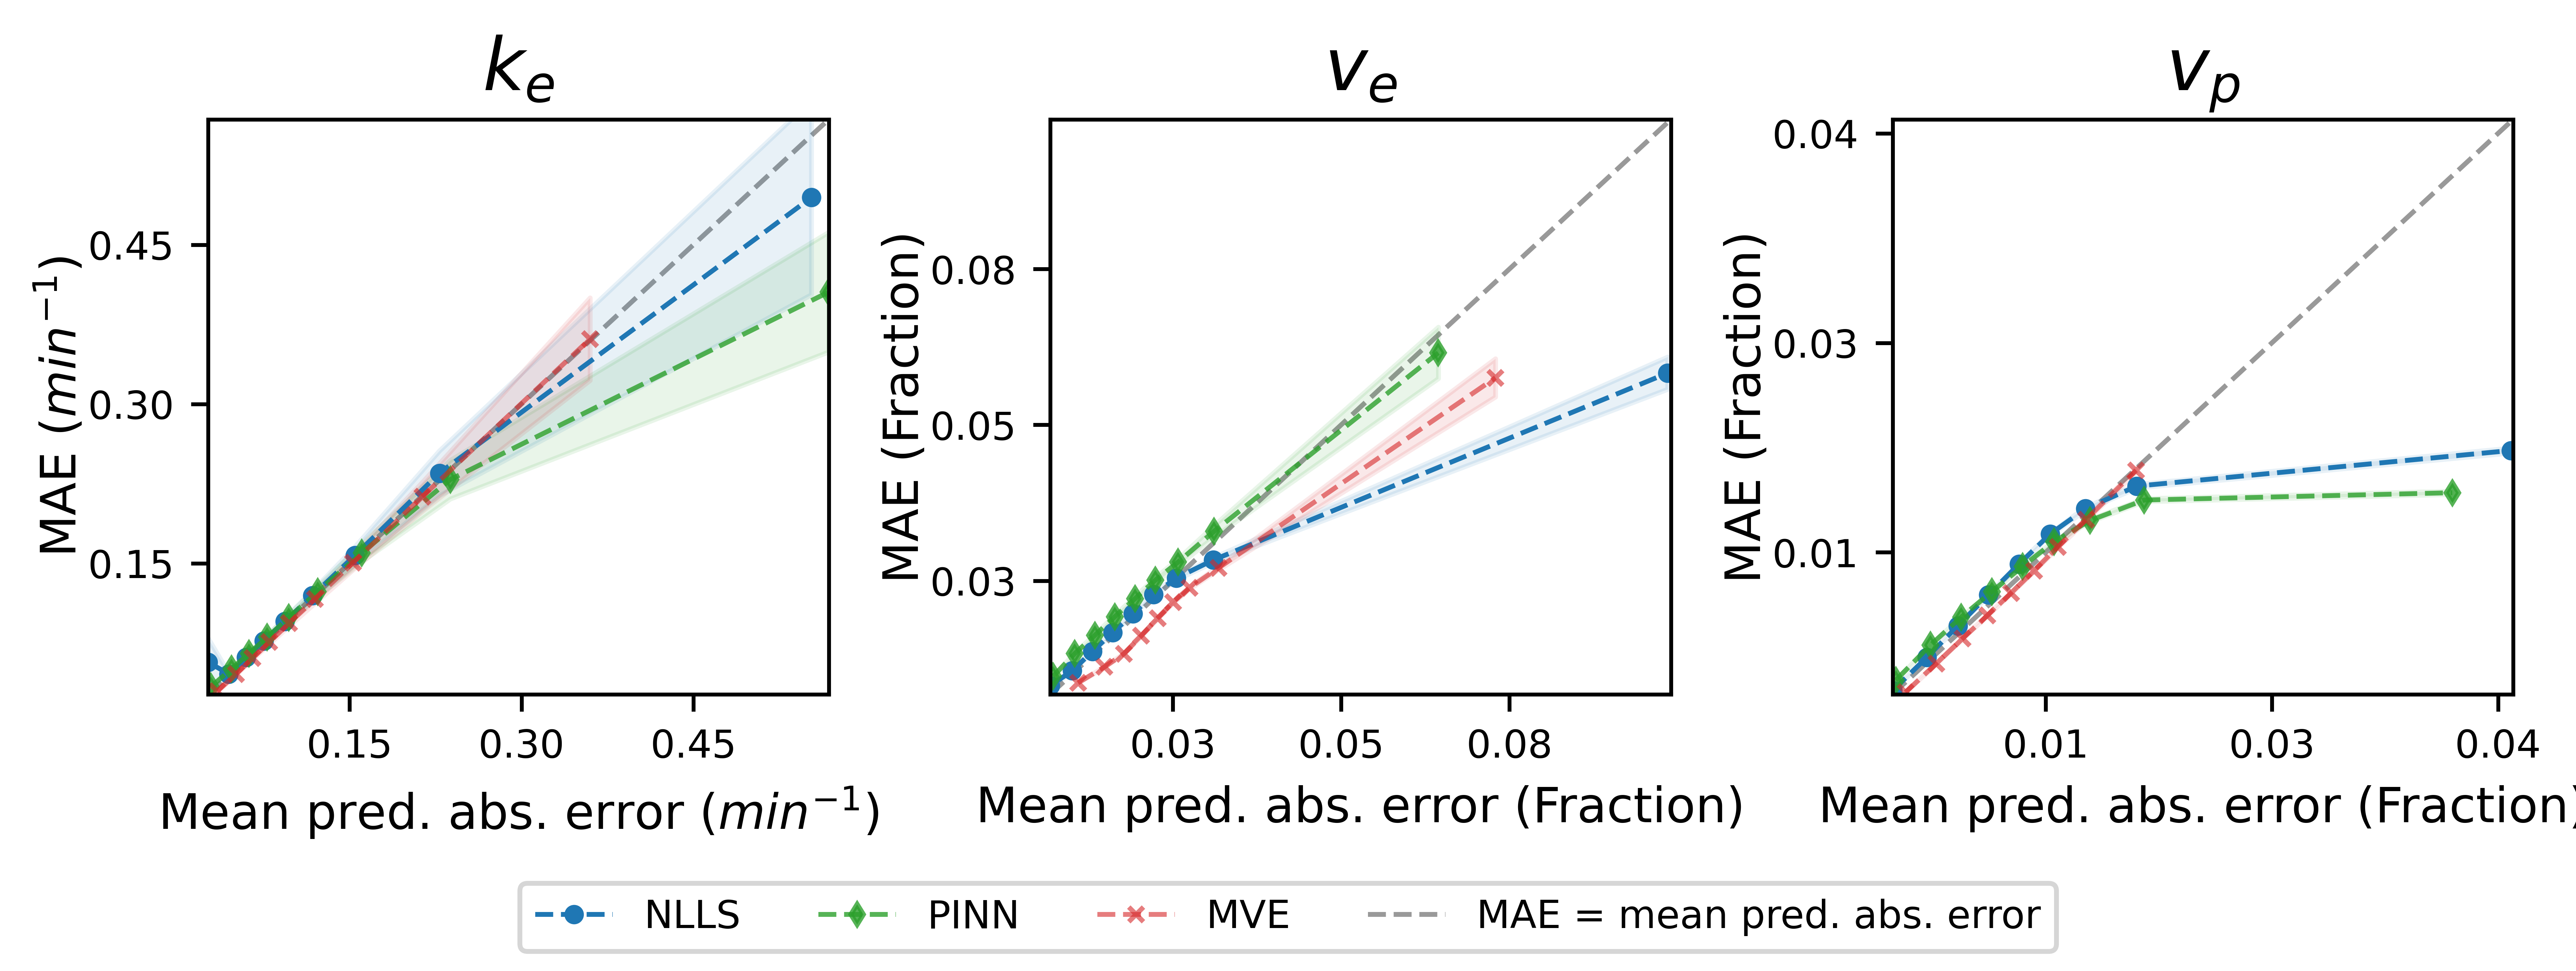

In [30]:
mode = "normal"
model_paths = {
    "NLLS" : "output/normal/nlls",
    # "snn" : "output/normal/snn_dcenet_1/predictions",
    "PINN" : "output/normal/pinn_ph_dcenet_0/predictions",
    "MVE" : "output/normal/mve_snn_dcenet_0/predictions",
    # "MVE (pi)" : "output/normal/mve_pinn_dcenet_3/predictions",
    # "MVE (ens)" : "output/normal/mve_snn_dcenet_ens/predictions",
    # "PINN (ens)" : "output/normal/pinn_ph_dcenet_ens/predictions",
}
data = np.load("data/sim/normal/test.npz")

fig = error_by_uncertainty(model_paths, data, mode, rm_outliers=True)
if save:
    fig.savefig(f"{outpath}/aleatoric/error_by_uncertainty.jpg", format='jpg', dpi=1000)

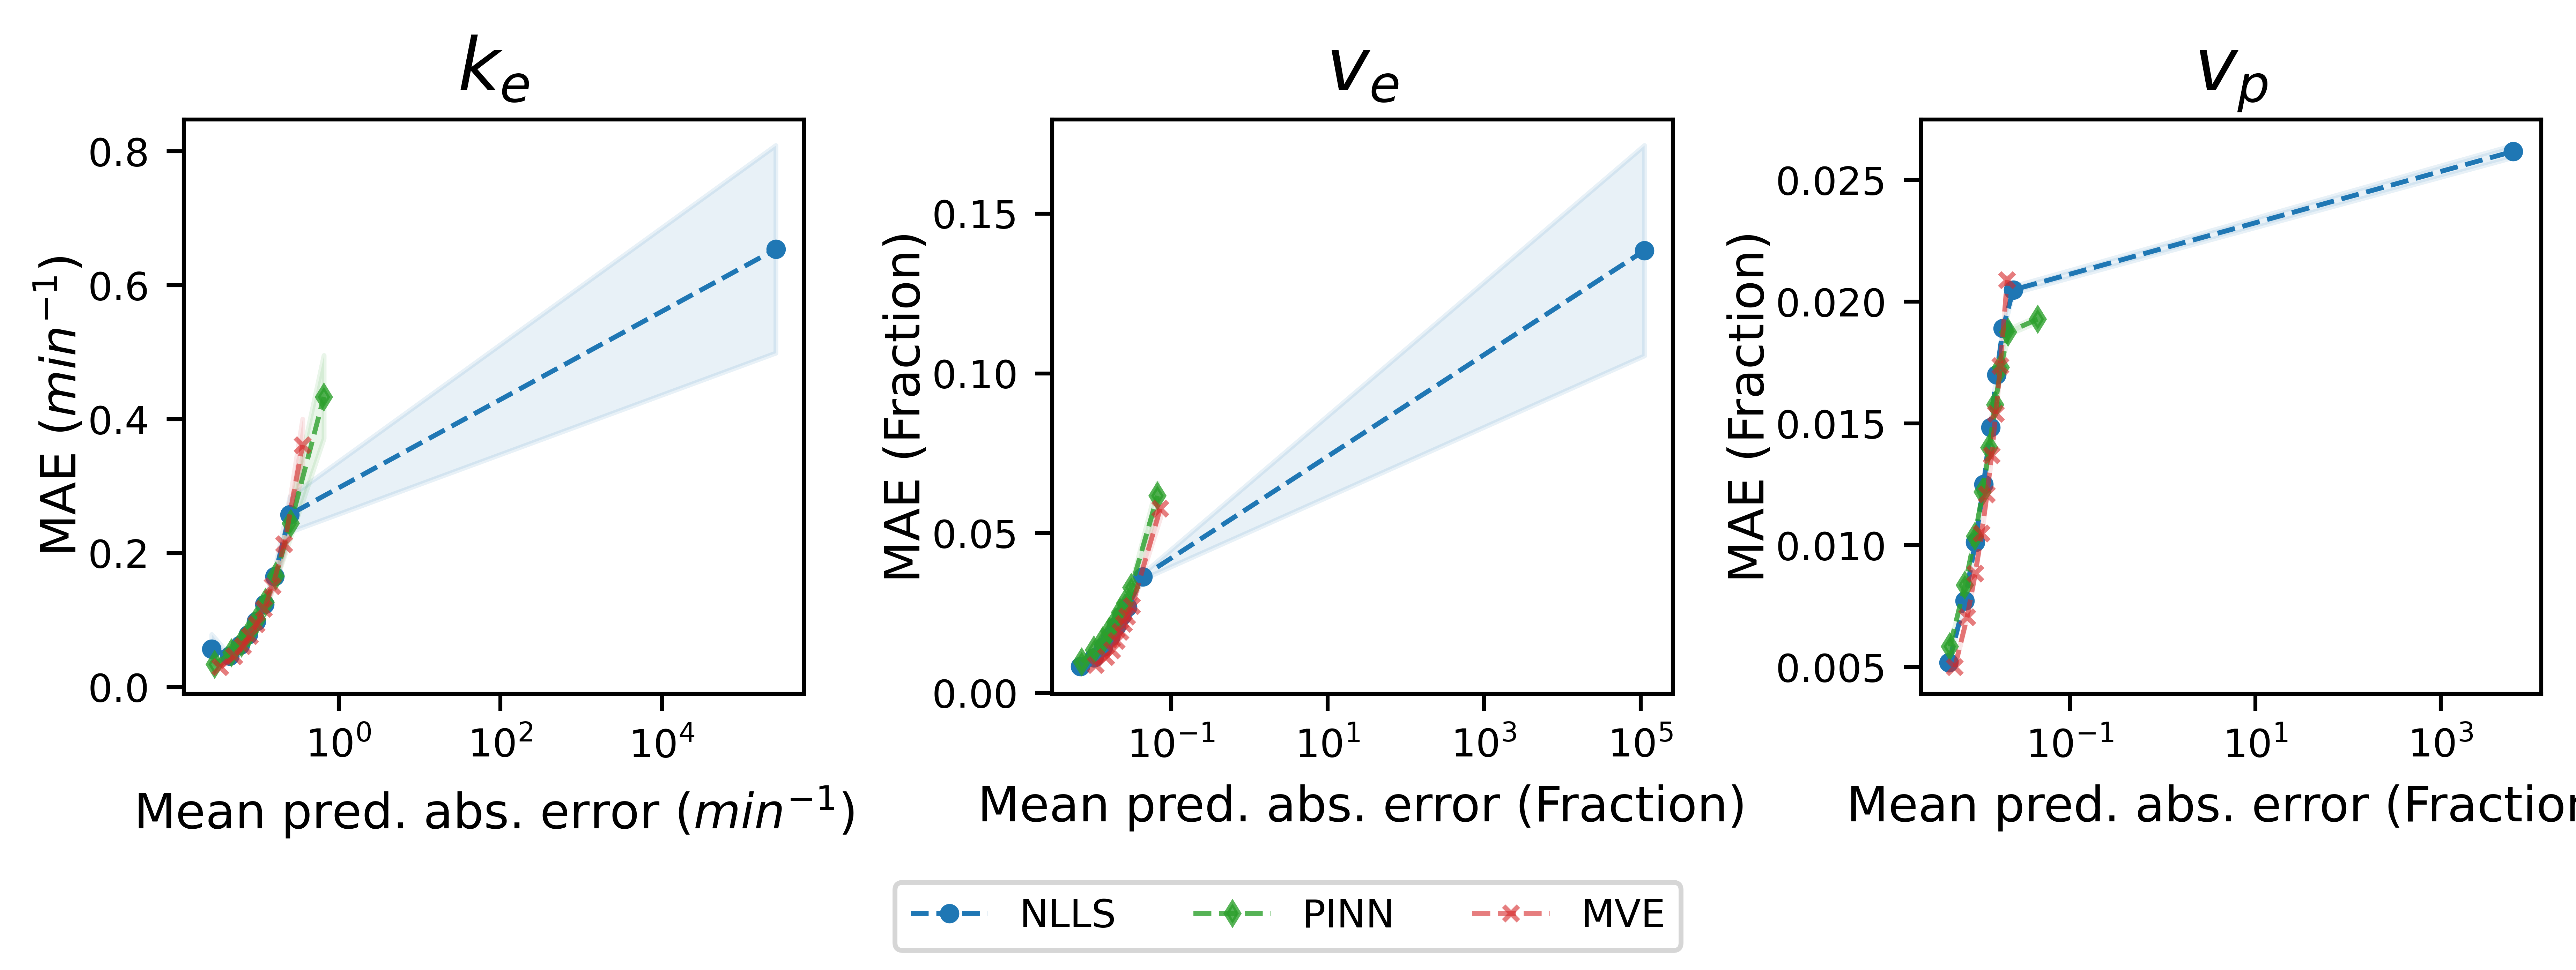

In [31]:
mode = "normal"
model_paths = {
    "NLLS" : "output/normal/nlls",
    # "snn" : "output/normal/snn_dcenet_1/predictions",
    "PINN" : "output/normal/pinn_ph_dcenet_0/predictions",
    "MVE" : "output/normal/mve_snn_dcenet_0/predictions",
    # "MVE (pi)" : "output/normal/mve_pinn_dcenet_3/predictions",
    # "MVE (ens)" : "output/normal/mve_snn_dcenet_ens/predictions",
    # "PINN (ens)" : "output/normal/pinn_ph_dcenet_ens/predictions",
}
data = np.load("data/sim/normal/test.npz")

fig = error_by_uncertainty(model_paths, data, mode, rm_outliers=False, log_x=True)
if save:
    fig.savefig(f"{outpath}/appendix/error_by_uncertainty_with_outliers.jpg", format='jpg', dpi=1000)

/var/folders/qr/7p6fvn3d4nd67dkshxhb1vt00000gn/T/ipykernel_10811/580682060.py:38: RuntimeWarning: Mean of empty slice.
  mean_error = [error[digitized == i].mean() for i in range(1, len(bins))]
/Users/jonase/opt/miniconda3/envs/uqb/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jonase/opt/miniconda3/envs/uqb/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jonase/opt/miniconda3/envs/uqb/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jonase/opt/miniconda3/envs/uqb/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/qr/7p

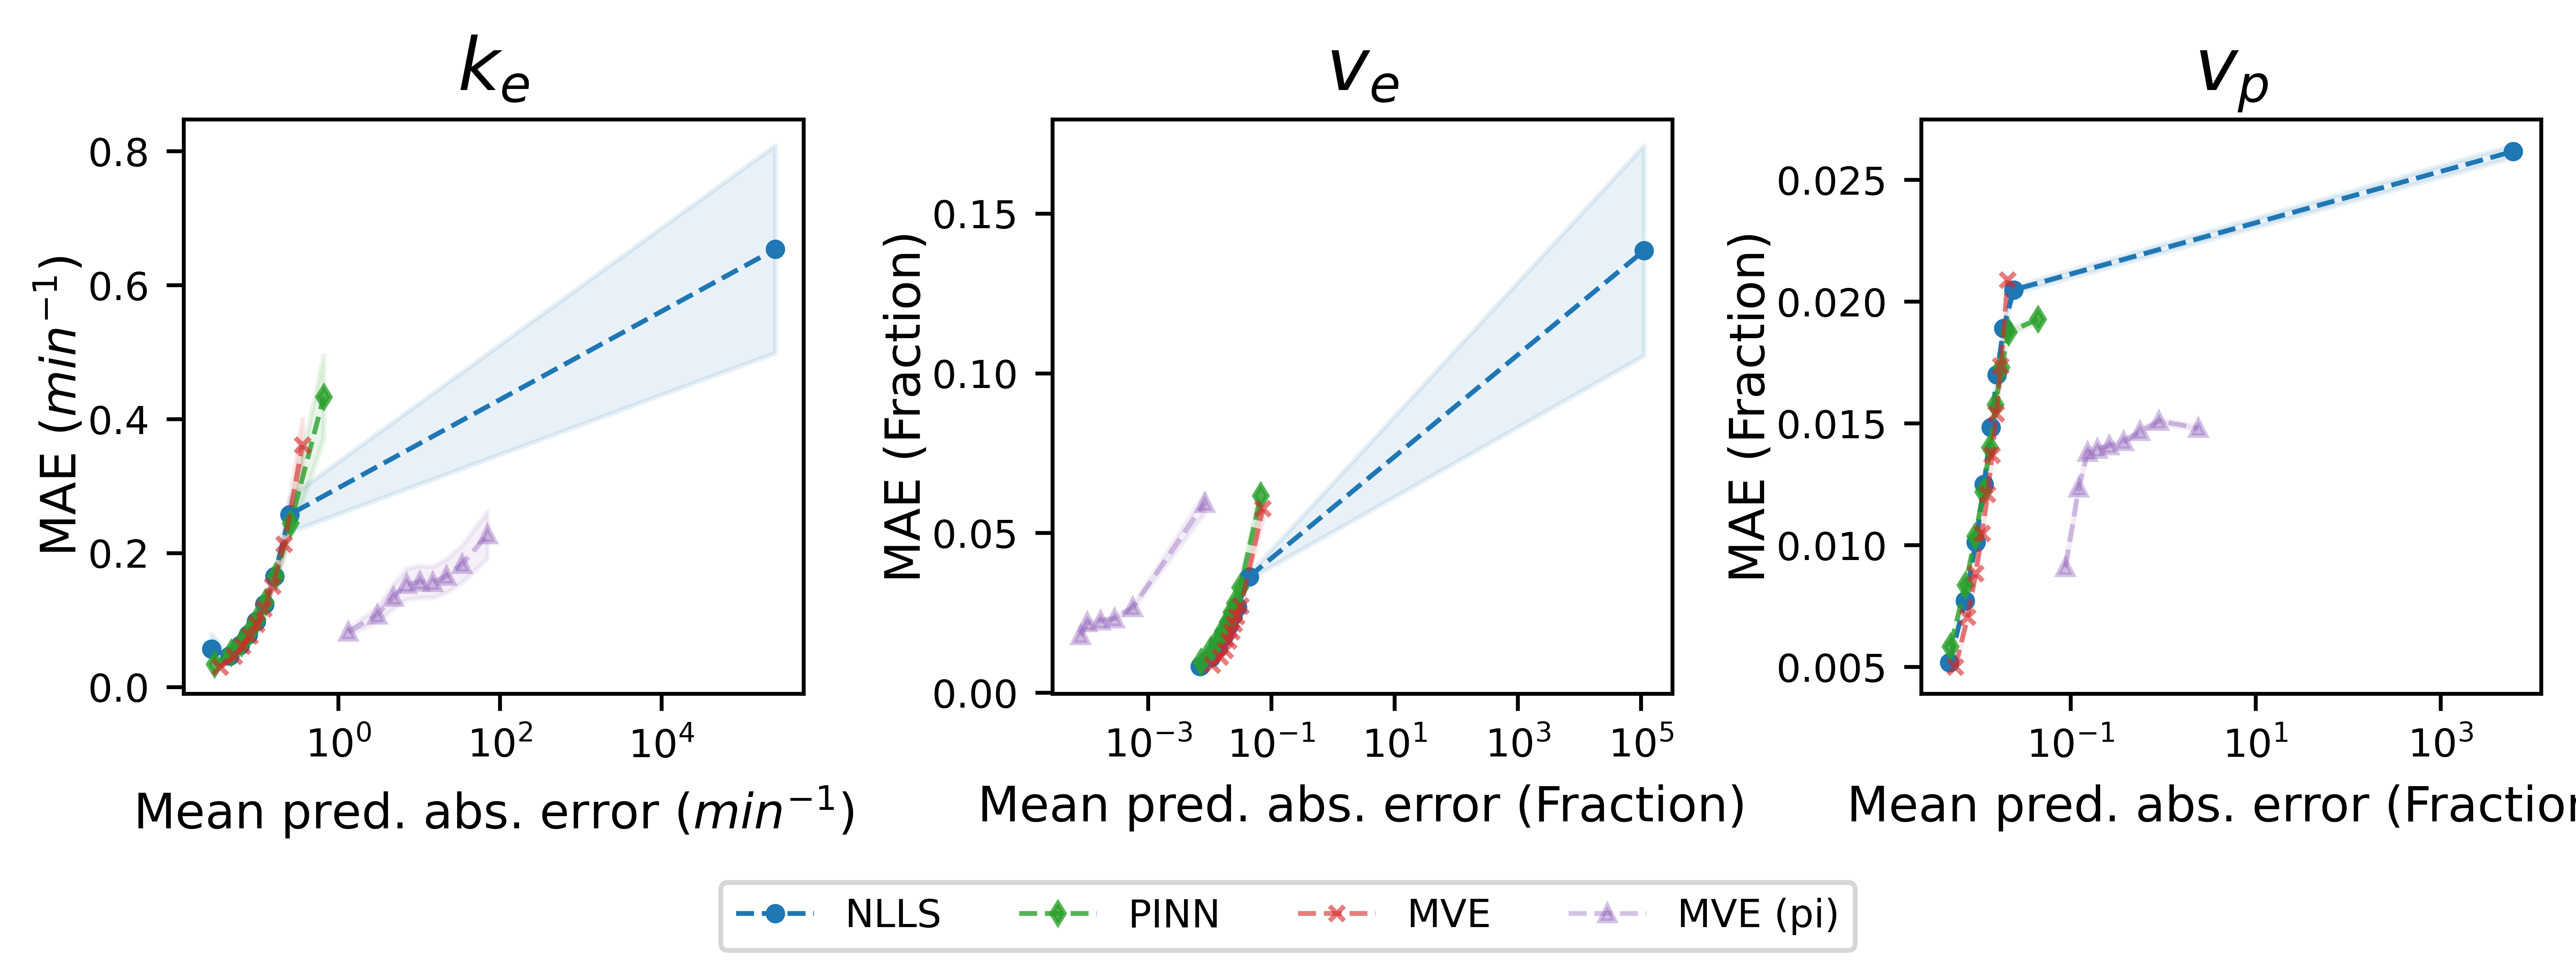

In [32]:
mode = "normal"
model_paths = {
    "NLLS" : "output/normal/nlls",
    # "snn" : "output/normal/snn_dcenet_1/predictions",
    "PINN" : "output/normal/pinn_ph_dcenet_0/predictions",
    "MVE" : "output/normal/mve_snn_dcenet_0/predictions",
    "MVE (pi)" : "output/normal/mve_pinn_dcenet_3/predictions",
    # "MVE (ens)" : "output/normal/mve_snn_dcenet_ens/predictions",
    # "PINN (ens)" : "output/normal/pinn_ph_dcenet_ens/predictions",
}
data = np.load("data/sim/normal/test.npz")

fig = error_by_uncertainty(model_paths, data, mode, rm_outliers=False, log_x=True)
if save:
    fig.savefig(f"{outpath}/appendix/error_by_uncertainty_with_pimve.jpg", format='jpg', dpi=1000)